In [27]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from reco_systems.filter import filter_df
from reco_systems.user_game_matrix import *

from surprise import NMF
from surprise import Dataset
from surprise.reader import Reader
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

In [28]:
folder = "../database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", index_col=0)

min_reviews = 10 # change to set one

In [29]:
# filter data with the minimum reviews
rev_filter = filter_df(avis_clean, min_reviews)

# create user-game matrix
user_game_ratings, mask_ratings, users_table_assoc, games_table_assoc = get_matrix_user_game(rev_filter)
filter_games_index = pd.merge(rev_filter["Game id"].drop_duplicates(), games_table_assoc.reset_index(), on="Game id")
filter_users_index = pd.merge(rev_filter["User id"].drop_duplicates(), users_table_assoc.reset_index(), on="User id")

filter_games_index.columns = ["Game id", "Game index"]
filter_users_index.columns = ["User id", "User index"]

11201 10549
2252 2676
1957 2618
1947 2616
1946 2615
1945 2614


In [33]:
users_tags = filter_users_index.merge(avis_clean, on="User id").merge(jeux_clean, on="Game id")[["User id", "Type"]]
users_tags["Type"] = users_tags["Type"].str.split("|")
users_tags = users_tags.explode("Type")
users_tags["Type"] = users_tags["Type"].str.strip().str.lower()
users_tags = users_tags.drop_duplicates()

users_tags = users_tags.pivot_table(index="User id", columns="Type", aggfunc="size", fill_value = 0, dropna=False)
users_tags

Type,abstrait,affrontement,afrique,alignement,amateur,ambiance,animaux,antiquité,archive,art,asie,astronomie et espace,autres,avant-vente,aventures dans la jungle,aviation,bande dessinée,blocage,bluff,bourse & finances,cambriolage,capture,card-driven,cartes à jouer,casse-tête,casual,catastrophe,chant & danse,chat,chiffres,chifoumi,choix simultanés,cirque,cochon,collection / famille,colonisation,combinaison,commerce,connaissances,connexions,...,prise de risque,programmation,prospection minière,préhistorique,puzzle,question,rails,rangement,rapidité,religion,renaissance,robots,récolte,rôle,rôle secret,samurai,science fiction,semaille,semi-coopération,simulation,sorcière,sport,steampunk,stop ou encore,super héros,taquin,toucher,trahison,transport de marchandise,tuile,tv & cinéma,vampire,vikings,ville,volcan,vote,zombies,équilibre,équipe,NaN
User id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,1,0,0,0,1,1,1,0,0,0,1,1,0,0,0,1,1,1,0,0,1,1,1,1,0,0,0,0,0,0,1,0,0,1,1,1,1,0,1,...,1,1,0,1,0,0,0,0,1,0,1,0,1,1,0,1,1,0,1,1,0,0,0,1,0,0,0,1,1,1,0,0,0,1,0,0,1,0,0,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,0,1,0,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1
3,1,1,0,1,1,1,1,1,0,1,1,0,1,0,0,0,1,1,1,0,0,1,1,1,0,1,1,0,0,0,0,1,1,0,1,1,1,1,0,1,...,1,1,0,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,0,0,1,1,0,1,0,1,1
4,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9509,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9583,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
9596,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,...,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1


## Games tags

In [35]:
games_filter = pd.merge(jeux_clean, filter_games_index, on="Game id")
games_exploded = games_filter.copy()
games_exploded["Type"] = games_filter["Type"].str.split('|')

games_exploded = games_exploded.explode("Type")
games_exploded["Type"] = games_exploded["Type"].str.strip().str.lower()
games_exploded = games_exploded.drop_duplicates()

games_tags = games_exploded.pivot_table(index="Game id", columns="Type", aggfunc='size', fill_value=0, dropna=False)
games_tags

Type,abstrait,affrontement,afrique,alignement,amateur,ambiance,animaux,antiquité,archive,art,asie,astronomie et espace,autres,avant-vente,aventures dans la jungle,aviation,bande dessinée,blocage,bluff,bourse & finances,capture,card-driven,cartes à jouer,casse-tête,casual,catastrophe,chiffres,choix simultanés,cirque,cochon,collection / famille,colonisation,combinaison,commerce,connaissances,connexions,conquête,construction,"contes, mythes & légendes",coopération,...,polaire,politique,prise de risque,programmation,prospection minière,préhistorique,question,rails,rangement,rapidité,religion,renaissance,robots,récolte,rôle,rôle secret,samurai,science fiction,semaille,semi-coopération,simulation,sorcière,sport,steampunk,stop ou encore,taquin,toucher,trahison,transport de marchandise,tuile,tv & cinéma,vampire,vikings,ville,volcan,vote,zombies,équilibre,équipe,NaN
Game id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
34,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10507,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10508,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10514,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Delete rare tags

In [36]:
tags_freq = pd.DataFrame(index=games_tags.columns)
tags_freq["Sum"] = games_tags.apply(sum, axis=0)
tags_freq = tags_freq.reset_index().sort_values(by="Sum", ascending=False)
tags_freq[tags_freq["Type"] == "alignement"]

# Delete unpopular tags
tags_filter = tags_freq[tags_freq["Sum"] >= 20]
games_tags = games_tags.loc[:, tags_filter["Type"].values]
users_tags = users_tags.loc[:, tags_filter["Type"].values]
games_tags.shape, tags_filter.shape, users_tags.shape

((2614, 86), (86, 2), (1945, 86))

Text(0, 0.5, 'Number of games')

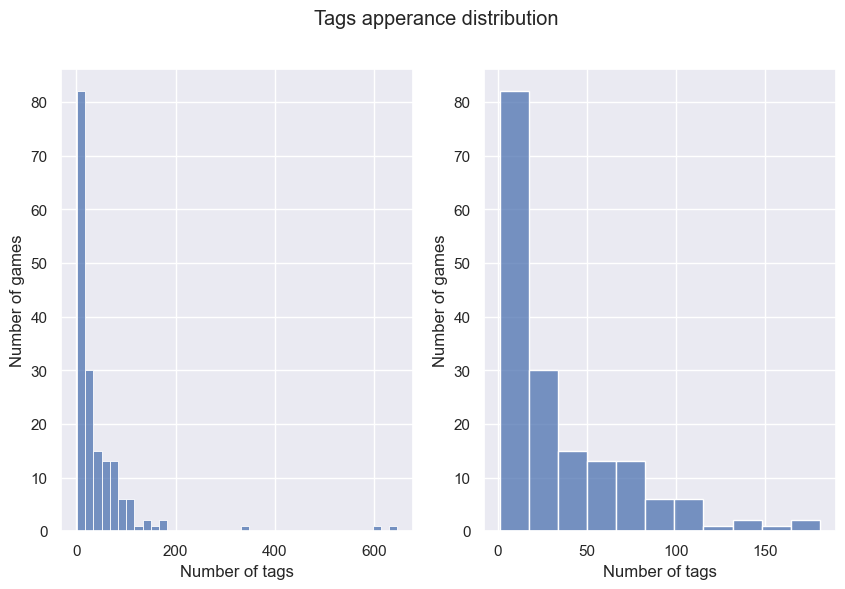

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
#sns.set_theme(rc={'figure.figsize':(6,4)})
sns.histplot(tags_freq["Sum"], ax=ax1)

tags_limit = tags_freq[tags_freq["Sum"] < 200]
sns.histplot(tags_limit["Sum"], ax=ax2)

plt.suptitle("Tags apperance distribution")
ax1.set_xlabel("Number of tags")
ax2.set_xlabel("Number of tags")

ax1.set_ylabel("Number of games")
ax2.set_ylabel("Number of games")


# NNMF

In [38]:
model = NMF(n_factors=30, random_state=42, biased=False, reg_pu= 0.1, reg_qi= 0.1)
data = Dataset.load_from_df(rev_filter[["User id", "Game id", "Rating"]], reader=Reader(rating_scale=(0, 10)))
trainset = data.build_full_trainset()
nmf = model.fit(trainset)

# Extract matrices
U = nmf.pu  # User-feature matrix (W)
G = nmf.qi  # Item-feature matrix (H)
G.shape

(2614, 30)

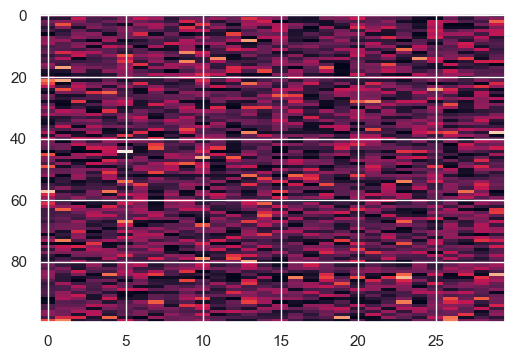

In [39]:
plt.imshow(G[:100, :], aspect="auto")

In [40]:
games_ids = [trainset.to_raw_iid(i) for i in range(len(G))]
users_ids = [trainset.to_raw_uid(u) for u in range(len(U))]
#G[games_ids, :]
len(users_ids)

#games_tags = games_tags.loc[games_ids]
#users_tags = users_tags.loc[users_ids]
users_tags

Type,jeux de plateau,NaN,jeux de cartes,"hasard (dé, cartes, ...)",placement,affrontement,combinaison,gestion,déplacement,médiéval-fantastique,majorité,gestion de main,dés,ambiance,bluff,exploration,médiéval,guerre,commerce,placement d'ouvrier,animaux,coopération,collection / famille,fantastique,prise de risque,choix simultanés,pioche,plateau modulaire,"contes, mythes & légendes",course,science fiction,déduction,blocage,conquête,tuile,antiquité,ville,diplomatie,deck building,construction,...,autres,asie,observation,points d'action,enchères,maritime,guessing,jeux de pions,objectif secret,récolte,connexions,stop ou encore,elimination,enquêtes et policiers,card-driven,locomotion & voyage,parcours,rôle secret,horreur,dextérité/adresse,trahison,narration,simulation,rôle,les îles,semi-coopération,divers,capture,politique,renaissance,draft,pirate,historique,jeu de logique,jeux de dés,pari,créativité,transport de marchandise,lettres / mots,zombies
User id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,0,1,0,1,0,1,1,0,1,0,1,0,1,1,0,1,0,0,1,0,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1
4,0,1,0,1,0,1,0,0,1,1,1,0,1,1,1,0,0,1,0,1,1,1,0,1,0,1,0,1,1,0,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9509,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9583,1,1,1,1,1,1,0,0,0,1,0,1,1,0,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9596,1,1,0,0,1,1,0,1,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1,1,1,0,1,1,0,1,...,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1


## Games clustering (NNMF profiles based)

([<matplotlib.lines.Line2D at 0x308af3850>],
 array([23, 24, 18, 19, 22, 21, 20, 17, 16, 14,  0, 13,  9,  1,  5,  2,  8,
        12,  3, 11, 15,  6,  7,  4, 10]))

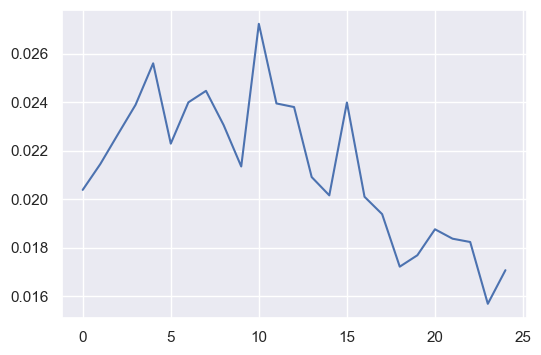

In [41]:
sns.set_theme(rc={"figure.figsize":(6, 4)})
scores = []
for n in range(5, 30):
    kmeans = KMeans(n_clusters=n, random_state=42) 
    kmeans.fit(G) 
    scores.append(silhouette_score(G, kmeans.labels_))

plt.plot(scores), np.argsort(scores)

<Axes: xlabel='Cluster', ylabel='Count'>

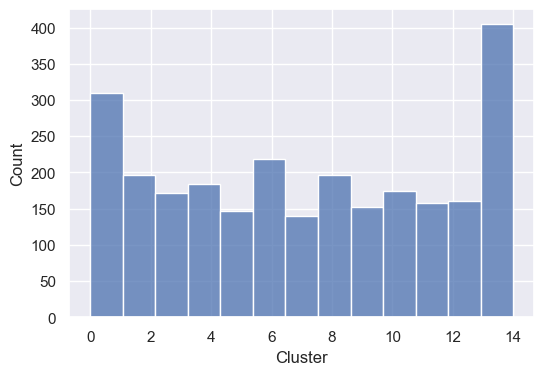

In [42]:
kmeans = KMeans(n_clusters=15, random_state=42) 
kmeans.fit(G) 
game_labels = kmeans.labels_ 

games_clusters = pd.DataFrame(data={"Game id":games_ids, "Cluster":game_labels})

# Distances from centrois
distances = cdist(G, kmeans.cluster_centers_, metric="euclidean")
#games_clusters.merge(distances, left_index=True, left_on=)
distances = pd.DataFrame({"Game id":games_ids, "Distance_centroid": np.take_along_axis(distances, games_clusters["Cluster"].values[..., None], axis=1).flatten()})
games_clusters = games_clusters.merge(distances, on="Game id")
games_clusters
sns.histplot(data=games_clusters["Cluster"])

<Axes: xlabel='Type', ylabel='Cluster'>

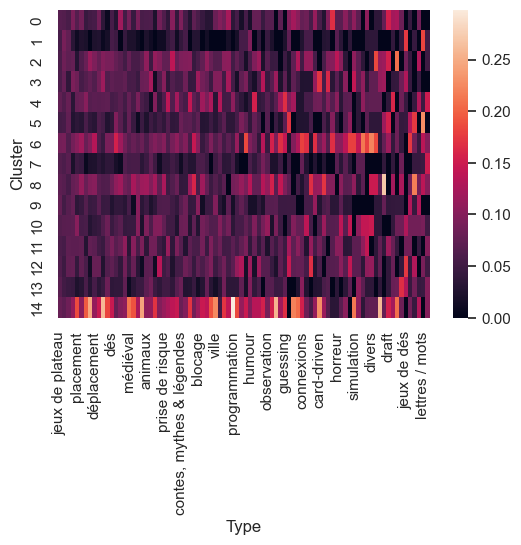

In [43]:
clusters_tags = games_clusters.pivot_table(index="Game id", columns="Cluster", aggfunc='size', fill_value=0).T @ games_tags
clusters_tags_normal = clusters_tags / clusters_tags.sum(axis=0) # normalize
sns.heatmap(clusters_tags_normal)

In [44]:
clusters_tags_df = clusters_tags_normal.stack().to_frame().reset_index()
clusters_tags_df.columns = ["Cluster", "Type", "Frequency"]
#clusters_tags_df.sort_values()
sorted = clusters_tags_df.groupby(by='Cluster', group_keys=False).apply(lambda x: x.sort_values('Frequency', ascending=False).head(10))
clusters_tags_df["Cluster"].unique()

/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_992/676035316.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sorted = clusters_tags_df.groupby(by='Cluster', group_keys=False).apply(lambda x: x.sort_values('Frequency', ascending=False).head(10))


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int32)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


Text(0.5, 0.98, 'Games clusters')

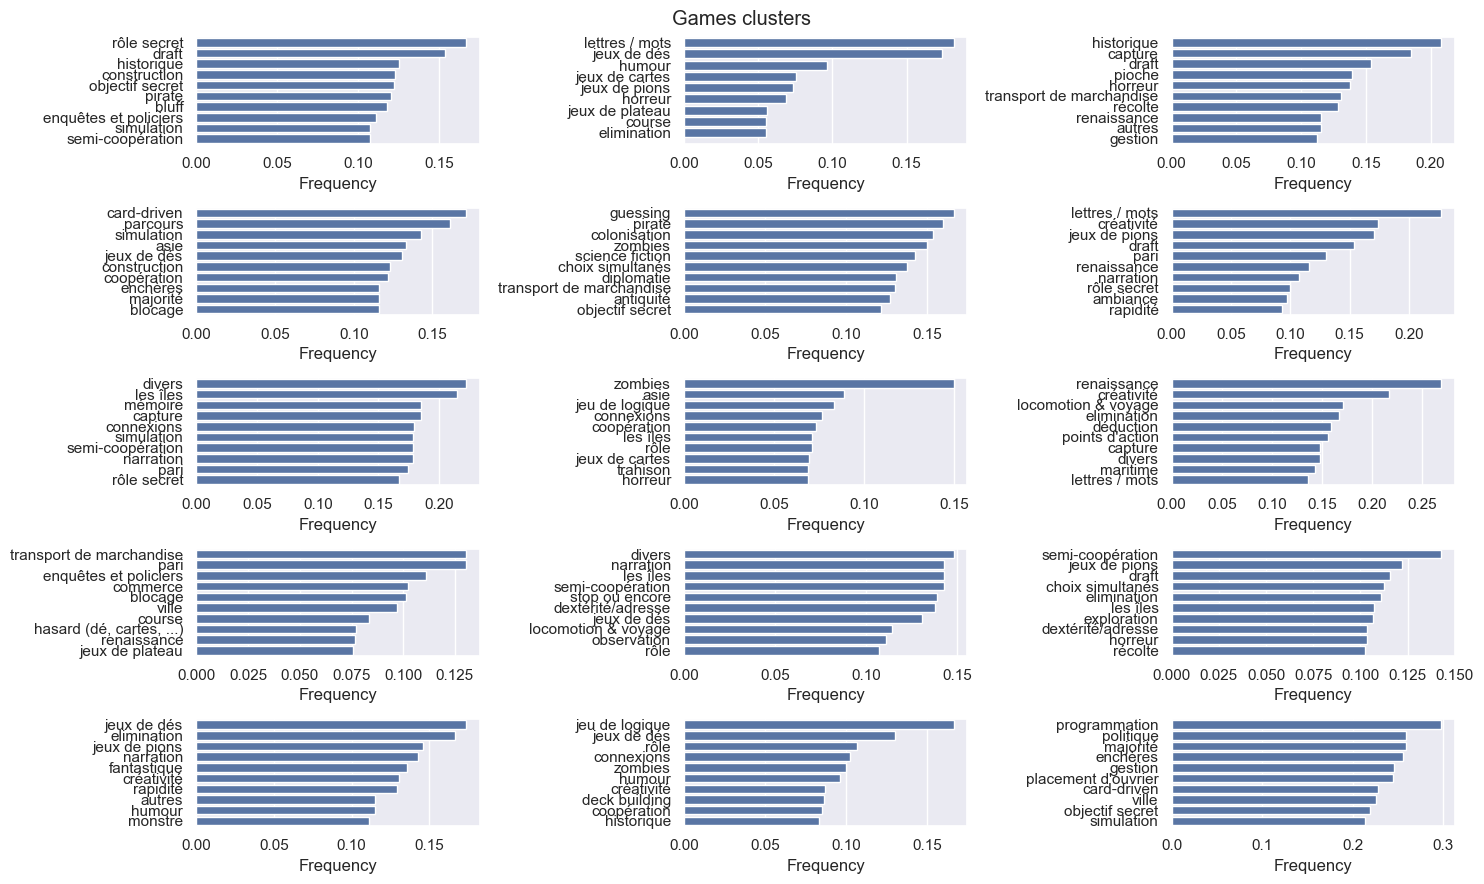

In [45]:
from itertools import product

fig, axes = plt.subplots(5, 3, figsize=(15, 9))
for i, j in product(range(5), range(3)):
    cluster = i * 3 + j
    #if cluster > 6:
        #break
    print(cluster)
    data = sorted[sorted["Cluster"] == cluster]
    bars = sns.barplot(data, y="Type", x="Frequency", ax=axes[i, j])
    bars.set_ylabel("")
    bars.set_yticks(range(10))

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.suptitle("Games clusters")

In [46]:
CD = games_clusters.pivot_table(index="Game id", columns="Cluster", values="Distance_centroid", fill_value=0).T
CS = games_clusters.pivot_table(index="Game id", columns="Cluster", aggfunc='size', fill_value=0).T
CS = CS / CS.sum(axis=0)
clusters_distances = (1 / (CD @ games_tags / CS.sum(axis=1).values[:, None] )).replace(np.inf, 0)
clusters_tags_dist = clusters_distances * clusters_tags / clusters_distances.sum(axis=1).values[:, None]
#clusters_tags_dist = clusters_distances
clusters_tags_dist

Type,jeux de plateau,NaN,jeux de cartes,"hasard (dé, cartes, ...)",placement,affrontement,combinaison,gestion,déplacement,médiéval-fantastique,majorité,gestion de main,dés,ambiance,bluff,exploration,médiéval,guerre,commerce,placement d'ouvrier,animaux,coopération,collection / famille,fantastique,prise de risque,choix simultanés,pioche,plateau modulaire,"contes, mythes & légendes",course,science fiction,déduction,blocage,conquête,tuile,antiquité,ville,diplomatie,deck building,construction,...,autres,asie,observation,points d'action,enchères,maritime,guessing,jeux de pions,objectif secret,récolte,connexions,stop ou encore,elimination,enquêtes et policiers,card-driven,locomotion & voyage,parcours,rôle secret,horreur,dextérité/adresse,trahison,narration,simulation,rôle,les îles,semi-coopération,divers,capture,politique,renaissance,draft,pirate,historique,jeu de logique,jeux de dés,pari,créativité,transport de marchandise,lettres / mots,zombies
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.038590,0.038259,0.038251,0.038579,0.038020,0.037114,0.040921,0.042260,0.038108,0.036477,0.041855,0.031685,0.035361,0.040117,0.040008,0.036490,0.040722,0.038155,0.041635,0.036988,0.041842,0.037800,0.041819,0.036250,0.038885,0.035808,0.038883,0.041790,0.036701,0.044516,0.041390,0.038660,0.037526,0.035536,0.039788,0.039721,0.042647,0.039235,0.037736,0.036985,...,0.035694,0.043523,0.036465,0.039429,0.000000,0.033331,0.000000,0.035069,0.039155,0.040525,0.033102,0.043512,0.028840,0.034207,0.036396,0.028948,0.037885,0.036138,0.034304,0.034186,0.039068,0.033742,0.038082,0.038935,0.000000,0.037429,0.000000,0.043421,0.031685,0.036985,0.044565,0.039355,0.037608,0.034526,0.000000,0.042334,0.000000,0.039513,0.000000,0.000000
1,0.029090,0.028294,0.026441,0.027305,0.023911,0.027538,0.027247,0.000000,0.025367,0.027318,0.029390,0.028175,0.030009,0.025429,0.000000,0.028648,0.028461,0.025715,0.037602,0.000000,0.024724,0.030525,0.000000,0.029658,0.038885,0.025551,0.031739,0.029390,0.027451,0.025386,0.000000,0.023478,0.035948,0.000000,0.029390,0.000000,0.000000,0.000000,0.000000,0.027588,...,0.020440,0.000000,0.019949,0.025950,0.000000,0.000000,0.020153,0.034319,0.000000,0.000000,0.034755,0.038862,0.021453,0.000000,0.000000,0.038302,0.024347,0.000000,0.023021,0.031662,0.000000,0.030525,0.000000,0.000000,0.000000,0.037226,0.030525,0.027588,0.000000,0.000000,0.000000,0.022664,0.000000,0.040153,0.026222,0.000000,0.030525,0.000000,0.031019,0.038885
2,0.040392,0.041266,0.035516,0.041150,0.045906,0.039396,0.041914,0.043730,0.045806,0.041094,0.044102,0.044715,0.042656,0.037552,0.038492,0.040418,0.036555,0.033801,0.041187,0.041040,0.043225,0.043680,0.042318,0.039510,0.042991,0.040150,0.040375,0.046989,0.042972,0.040098,0.038901,0.039133,0.048417,0.040734,0.042511,0.048207,0.044527,0.037932,0.037127,0.045109,...,0.038139,0.048817,0.043706,0.034564,0.037842,0.000000,0.039853,0.033674,0.046645,0.048457,0.042280,0.043349,0.037975,0.043790,0.000000,0.048980,0.052576,0.032919,0.039681,0.051277,0.039004,0.000000,0.039454,0.046117,0.039004,0.000000,0.031297,0.049354,0.030994,0.043943,0.045325,0.000000,0.041555,0.000000,0.042055,0.035728,0.000000,0.044760,0.000000,0.051561
3,0.029402,0.030083,0.026676,0.030938,0.033707,0.030757,0.033779,0.032246,0.028088,0.031475,0.034827,0.028341,0.031611,0.028299,0.032012,0.028766,0.031138,0.030245,0.029716,0.031491,0.029627,0.028766,0.023209,0.027916,0.034850,0.035370,0.035014,0.032464,0.029663,0.032207,0.030896,0.036225,0.035091,0.030711,0.033174,0.031060,0.031022,0.028076,0.029611,0.031198,...,0.024062,0.030877,0.034969,0.042237,0.030657,0.029237,0.035382,0.030595,0.025952,0.033195,0.036757,0.057770,0.034078,0.035893,0.028794,0.036767,0.035013,0.034933,0.030463,0.044456,0.030577,0.000000,0.026901,0.029734,0.030794,0.025946,0.024726,0.033490,0.037057,0.034161,0.000000,0.031686,0.023493,0.023202,0.033812,0.035924,0.000000,0.036776,0.000000,0.000000
4,0.031247,0.032749,0.027803,0.029439,0.037022,0.0323

In [47]:
clusters_tags_df = clusters_tags_dist.stack().to_frame().reset_index()
clusters_tags_df.columns = ["Cluster", "Type", "Weight"]
#clusters_tags_df.sort_values()
sorted = clusters_tags_df.groupby(by='Cluster', group_keys=False).apply(lambda x: x.sort_values('Weight', ascending=False).head(10))
sorted[sorted["Cluster"] == 2]

/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_992/3860701259.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sorted = clusters_tags_df.groupby(by='Cluster', group_keys=False).apply(lambda x: x.sort_values('Weight', ascending=False).head(10))


,Cluster,Type,Weight
234,2,parcours,0.052576
257,2,zombies,0.051561
237,2,dextérité/adresse,0.051277
245,2,capture,0.049354
233,2,locomotion & voyage,0.048980
219,2,asie,0.048817
227,2,récolte,0.048457
204,2,blocage,0.048417
207,2,antiquité,0.048207
199,2,plateau modulaire,0.046989


Text(0.5, 0.98, 'Games clusters (1 / distance from centroid)')

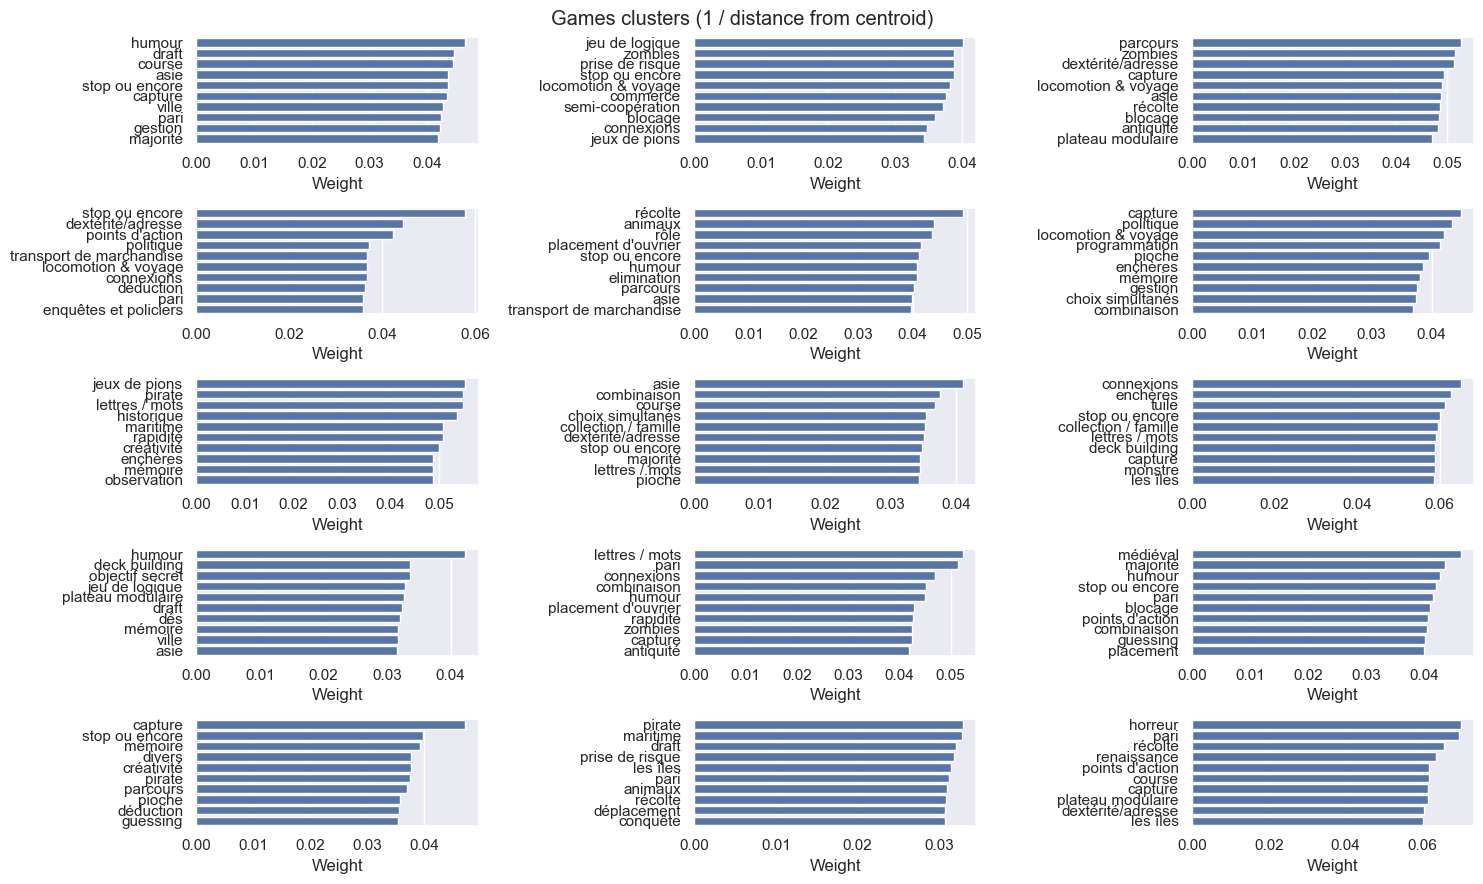

In [48]:
fig, axes = plt.subplots(5, 3, figsize=(15, 9))
for i, j in product(range(5), range(3)):
    cluster = i * 3 + j
    
    data = sorted[sorted["Cluster"] == cluster]
    bars = sns.barplot(data, y="Type", x="Weight", ax=axes[i, j])
    bars.set_ylabel("")
    bars.set_yticks(range(10))

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.suptitle("Games clusters (1 / distance from centroid)")

Text(0.5, 1.0, 'Centroids as latent factors')

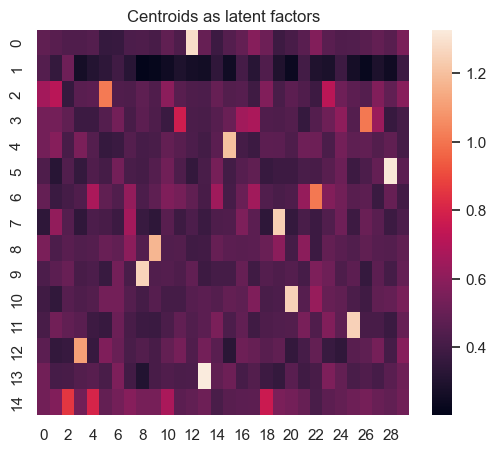

In [49]:
sns.set_theme(rc={"figure.figsize" : (6, 5)})
ax = sns.heatmap(kmeans.cluster_centers_)

ax.set_title("Centroids as latent factors")

| Centroid | Dominant latent factor meaning |
| -------- | ------------------------------ |
| 0        | 12 : narration, pirate, diplomatie |
| 1        |  |
| 2 | 5 : capture, 23 : draft, colonisation, 1 : récolte, politique |
| 3 | 11 : narration, horreur, coopération, 26 : placement d'ouvrier, asie, îles |
| 4 | 15 : enquêtes & policiers |
| 5 | 28 : sémi-coopération, rennaissance |
| 6 | 22 : sémi-coopération |
| 7 | 19 : maritime |
| 8 | 9 : science-fiction |
| 9 | 8 : rennaissance, transport de marchandise |
| 10 | 20 : transport de marchandise |
| 11 | 25 : monstre, maritime |
| 12 | 3 : antiquité, fantastique, gestion de main, deck-building |
| 13 | 13 : points d'action, transport de marchandise, locomotion |
| 14 | 2 : card-driven, enquêtes & policiers, autres, capture |

## Co-occurence matrix

In [50]:
# !!! Important to reorder BEFORE projection
games_tags = games_tags.loc[games_ids]

cooc_matrix = games_tags.T @ games_tags
np.fill_diagonal(cooc_matrix.values, val=0)
cooc_freq = cooc_matrix.apply(sum, axis=1)
cooc_matrix = cooc_matrix.sort_values(by=cooc_matrix.columns.tolist(), ascending=False)
cooc_matrix.iloc[:15, :15]

Type,jeux de plateau,NaN,jeux de cartes,"hasard (dé, cartes, ...)",placement,affrontement,combinaison,gestion,déplacement,médiéval-fantastique,majorité,gestion de main,dés,ambiance,bluff
Type,,,,,,,,,,,,,,,
placement,42,0,8,21,0,17,23,31,19,10,47,17,19,2,10
déplacement,33,0,1,31,19,29,5,18,0,10,10,10,19,7,9
"hasard (dé, cartes, ...)",31,0,17,0,21,39,31,17,31,35,15,25,36,22,14
majorité,28,0,8,15,47,6,17,26,10,9,0,14,4,0,10
gestion,23,0,1,17,31,12,36,0,18,5,26,15,11,2,4
affrontement,22,0,13,39,17,0,15,12,29,36,6,25,28,15,15
dés,21,0,3,36,19,28,19,11,19,16,4,11,0,9,7
commerce,20,0,6,12,20,7,15,33,17,3,10,8,7,3,6
médiéval,19,0,8,10,21,11,19,22,8,5,21,13,9,6,9


<Axes: ylabel='Type'>

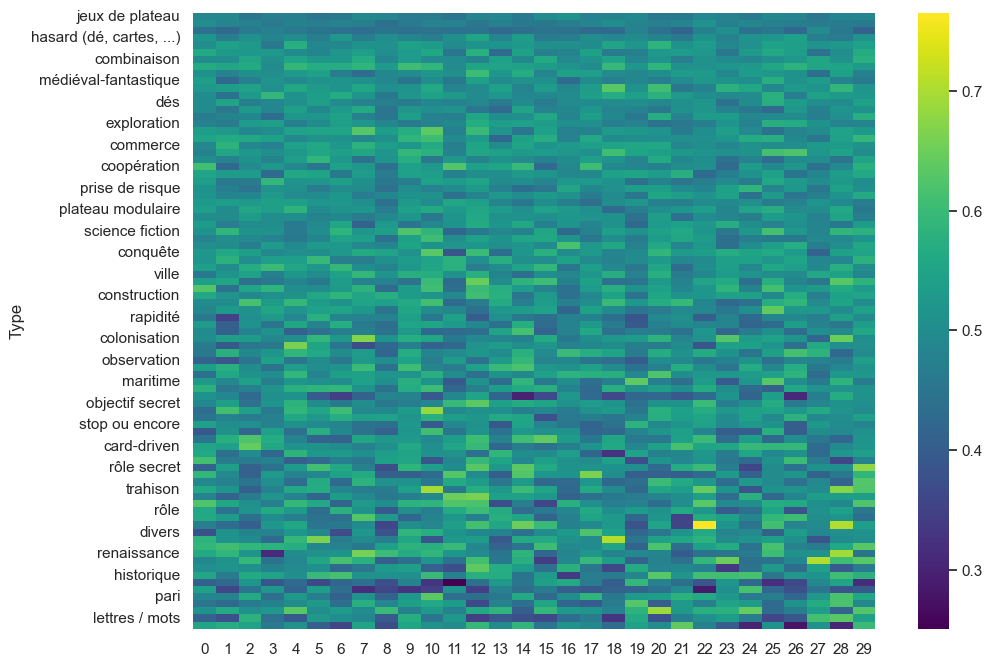

In [51]:
games_count_encode = games_tags / games_tags.sum(axis=0)

games_proj = games_count_encode.T @ G

sns.set_theme(rc={'figure.figsize':(11,8)})
sns.heatmap(games_proj, cmap="viridis")
#plt.grid(False)

In [52]:
games_proj

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
jeux de plateau,0.488250,0.488756,0.452832,0.466045,0.470668,0.450301,0.459573,0.490933,0.483896,0.462592,0.462373,0.446434,0.482147,0.487617,0.461007,0.496858,0.510397,0.477484,0.479907,0.490228,0.458121,0.457949,0.487531,0.477713,0.461353,0.491654,0.484685,0.453952,0.485637,0.486712
NaN,0.500964,0.483718,0.474215,0.461111,0.474011,0.466461,0.477663,0.471119,0.438742,0.460305,0.479655,0.478307,0.454207,0.472427,0.458678,0.456706,0.466934,0.483550,0.501883,0.481421,0.467974,0.485687,0.514585,0.475137,0.487990,0.472960,0.467158,0.462444,0.463454,0.461173
jeux de cartes,0.440215,0.421791,0.459751,0.472017,0.461556,0.448579,0.445259,0.433963,0.449458,0.441677,0.446230,0.443189,0.447268,0.423292,0.436190,0.447162,0.443828,0.426486,0.428387,0.476905,0.444035,0.415804,0.475547,0.504816,0.444917,0.456118,0.422056,0.494577,0.456390,0.413106
"hasard (dé, cartes, ...)",0.520903,0.466430,0.509658,0.484679,0.503511,0.470022,0.522387,0.471034,0.500882,0.483038,0.467721,0.507069,0.554799,0.484085,0.535768,0.465455,0.468835,0.500550,0.487623,0.497891,0.480296,0.461234,0.510769,0.479765,0.515746,0.518263,0.540963,0.471165,0.465614,0.514272
placement,0.503110,0.542796,0.523700,0.455958,0.576025,0.486537,0.488275,0.513462,0.508687,0.542899,0.532437,0.495866,0.513922,0.516780,0.526232,0.507770,0.506510,0.498997,0.548977,0.518389,0.583983,0.511943,0.532014,0.489288,0.509872,0.542222,0.538598,0.515388,0.523667,0.540759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pari,0.484520,0.479934,0.563505,0.436725,0.525050,0.470746,0.412821,0.510503,0.411671,0.525321,0.636250,0.433639,0.436991,0.456898,0.562444,0.427021,0.500023,0.584363,0.457760,0.529007,0.535452,0.581675,0.560946,0.524636,0.461162,0.470919,0.421359,0.524796,0.617693,0.556572
créativité,0.449921,0.424513,0.462902,0.474903,0.499283,0.526481,0.439435,0.574406,0.486049,0.539330,0.559943,0.532289,0.363395,0.479951,0.434323,0.554135,0.421254,0.398284,0.462476,0.628207,0.399514,0.529240,0.469960,0.548856,0.534005,0.426740,0.513103,0.565617,0.617152,0.490884
transport de marchandise,0.510051,0.562017,0.505411,0.523350,0.630978,0.503752,0.531631,0.495903,0.599952,0.473708,0.527693,0.475715,0.560706,0.585696,0.402194,0.594247,0.529207,0.519243,0.479358,0.583397,0.687304,0.529151,0.577589,0.578350,0.643445,0.432958,0.470548,0.536528,0.415396,0.626597


{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [65.0, 65.0, 75.0, 75.0],
  [55.0, 55.0, 70.0, 70.0],
  [40.0, 40.0, 62.5, 62.5],
  [25.0, 25.0, 51.25, 51.25],
  [10.0, 10.0, 38.125, 38.125],
  [85.0, 85.0, 95.0, 95.0],
  [105.0, 105.0, 115.0, 115.0],
  [90.0, 90.0, 110.0, 110.0],
  [125.0, 125.0, 135.0, 135.0],
  [145.0, 145.0, 155.0, 155.0],
  [165.0, 165.0, 175.0, 175.0],
  [150.0, 150.0, 170.0, 170.0],
  [130.0, 130.0, 160.0, 160.0],
  [185.0, 185.0, 195.0, 195.0],
  [205.0, 205.0, 215.0, 215.0],
  [235.0, 235.0, 245.0, 245.0],
  [225.0, 225.0, 240.0, 240.0],
  [210.0, 210.0, 232.5, 232.5],
  [190.0, 190.0, 221.25, 221.25],
  [255.0, 255.0, 265.0, 265.0],
  [275.0, 275.0, 285.0, 285.0],
  [295.0, 295.0, 305.0, 305.0],
  [280.0, 280.0, 300.0, 300.0],
  [335.0, 335.0, 345.0, 345.0],
  [355.0, 355.0, 365.0, 365.0],
  [340.0, 340.0, 360.0, 360.0],
  [325.0, 325.0, 350.0, 350.0],
  [315.0, 315.0, 337.5, 337.5],
  [290.0, 290.0, 326.25, 326.25],
  [260.0, 260.0, 308.125

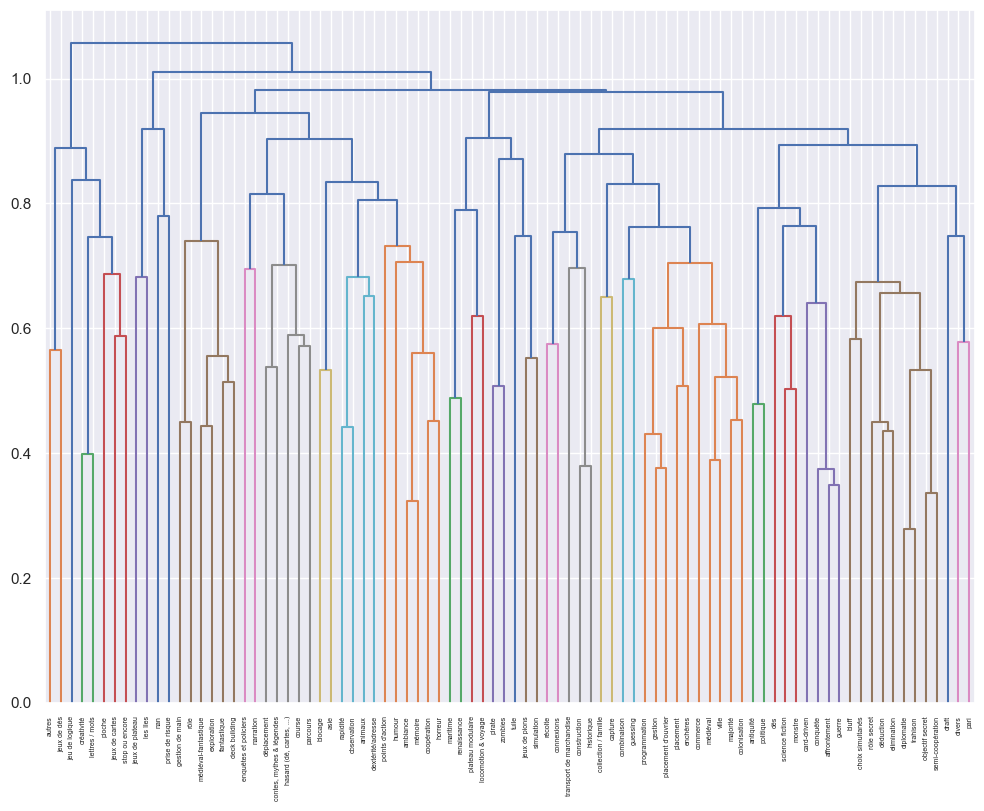

In [56]:
linkage_matrix=linkage(games_proj,method='average', metric="correlation")

fig = plt.figure(figsize=(12,9))
dendrogram(linkage_matrix, labels=games_proj.index, leaf_rotation=90)
# fig.savefig('myimage.svg', format='svg', dpi=1200)

In [54]:
clusters = fcluster(linkage_matrix, 0.78, "distance")
tags_clusters = pd.DataFrame(data={"Type":games_tags.columns.to_numpy(), "Cluster":clusters})
tags_clusters.groupby("Cluster").agg({"Type":list})

#score = silhouette_score(games_tags, clusters, metric="euclidean")
#print(f"Silhouette Score: {score}", np.unique(clusters).size)
tags_clusters.groupby("Cluster").count().sort_values("Type", ascending=False), np.unique(clusters).size

(         Type
 Cluster      
 18         12
 21          9
 20          7
 6           6
 11          6
 8           5
 2           5
 16          5
 10          4
 22          3
 15          3
 19          2
 17          2
 1           2
 14          2
 13          2
 9           2
 7           2
 4           2
 12          2
 5           1
 3           1,
 22)

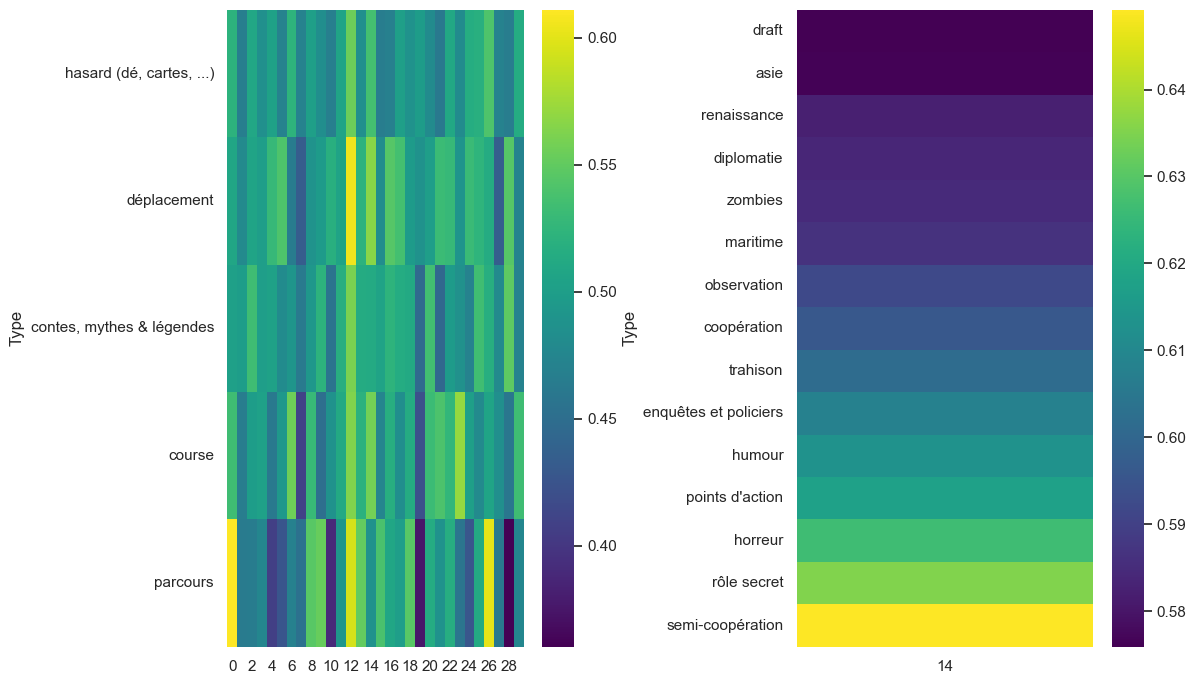

In [57]:
CLUSTER = 8
sns.set_theme(rc={"figure.figsize" : (12, 7)})

sel_types = tags_clusters[tags_clusters["Cluster"] == CLUSTER]["Type"].values
#sel_tags = games_proj.loc[["médiéval-fantastique", "fantastique"], :]
sel_tags = games_proj.loc[sel_types, :]
    

#sns.heatmap(games_proj.loc[:, [CLUSTER]].sort_values(by=CLUSTER).tail(25), cmap="viridis")
#sel_tags = games_proj.loc[sel_types, :]
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.heatmap(sel_tags, cmap="viridis", ax=ax1, cbar=True)
COMPONENT = 14
sns.heatmap(games_proj.loc[:, [COMPONENT]].sort_values(by=COMPONENT).tail(15), cmap="viridis", ax=ax2, cbar=True)
plt.tight_layout()

| Cluster | Common theme |
| ------- | ------------ |
| 8 | Jeux qui basé sur la commerce, gestion, époque médieval |
| 21 | Bluff, rôle secret, sémi-coopération |
| 12 | Affrontement, conflit, compétition |
| 16 | Fantastique |
| 19 | Immersive, coopération |
| 2 | Gestion, économie |
---

| Component | Meaning |
| --------  | ------- |
| 0 | Deck building |
| 1 | Gesion, commerce **non rapide**|
| 2 | Card-driven, draft |
| 3 | Antiquité, fantastique |
| 4 | Autres |
| 5 | Capture |
| 6 | Historique avec des cartes |
| 7 | Colonisaton dans rennaissance ou médieval -> contrôl des ressources |
| 8 | Exploration, gestion stratégique des ressources (en rennaissance) |
| 9 | Science-fiction |
| 10 | Compétitif (en médieval) |
| 11 | Lore riche + horreur | 
| 12 | Manipulation |
| 13 | Gestion des ressources + mouvement |
| 14 | Sémi-coopération, role secret, horreur | 
| 15 | enquêtes & policiers |
| 16 | Blocage -> compétition|
| 17 | Horreur | 
| 18 | Capture |
| 19 | Maritime, logique et créativité |
| 20 | Tranport de marchandise, gestion des ressources (historique) |
| 21 | zombies |
| 22 | sémi-coopération |
| 23 | draft (cartes) |
| 24 | Tranport  de marchandise, gestion des ressources (historique) |
| 25 | monstre + maritime |
| 26 | déplacement ?
| 27 | draft |
| 28 | sémi-coopération trahison en rennaissance |
| 29 | rôle secret |

([<matplotlib.lines.Line2D at 0x308f04410>],
 array([16, 17, 21, 19, 24, 18, 20, 23, 22, 13, 14, 15, 10,  9, 11,  8,  0,
         7,  5, 12,  1,  4,  2,  3,  6]))

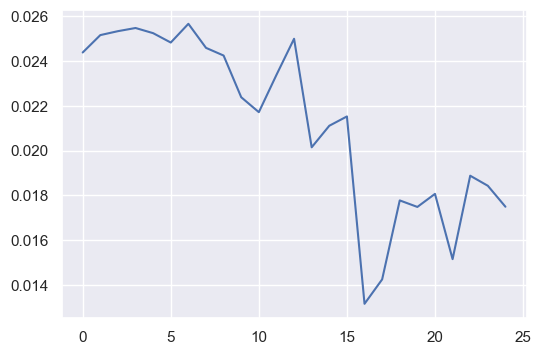

In [58]:
sns.set_theme(rc={"figure.figsize":(6, 4)})
scores = []
for n in range(5, 30):
    kmeans = KMeans(n_clusters=n, random_state=42) 
    kmeans.fit(U) 
    scores.append(silhouette_score(U, kmeans.labels_))

plt.plot(scores), np.argsort(scores)

In [60]:
kmeans_users = KMeans(n_clusters=6, random_state=42).fit(U)
users_labels = kmeans.labels_ 

Text(0.5, 1.0, 'Users centroids on latent factors')

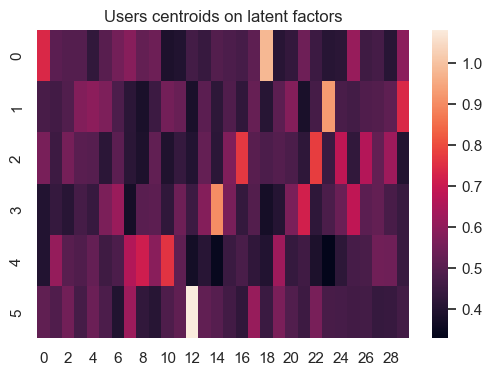

In [61]:
ax = sns.heatmap(kmeans_users.cluster_centers_)
ax.set_title("Users centroids on latent factors")

<Axes: xlabel='Cluster', ylabel='Count'>

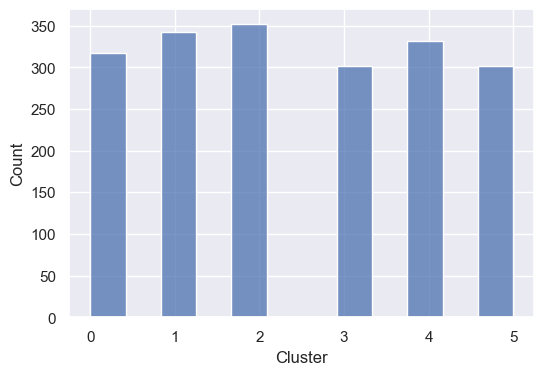

In [62]:
users_clusters = pd.DataFrame(data={"User id":users_ids, "Cluster":kmeans_users.labels_})
sns.histplot(users_clusters["Cluster"])

In [63]:
clusters_users_tags = users_clusters.pivot_table(index="User id", columns="Cluster", aggfunc='size', fill_value=0).T 
#clusters_users_tags_normal = clusters_tags / clusters_tags.sum(axis=0) # normalize
#sns.heatmap(clusters_tags_normal)


<Axes: xlabel='Type', ylabel='Cluster'>

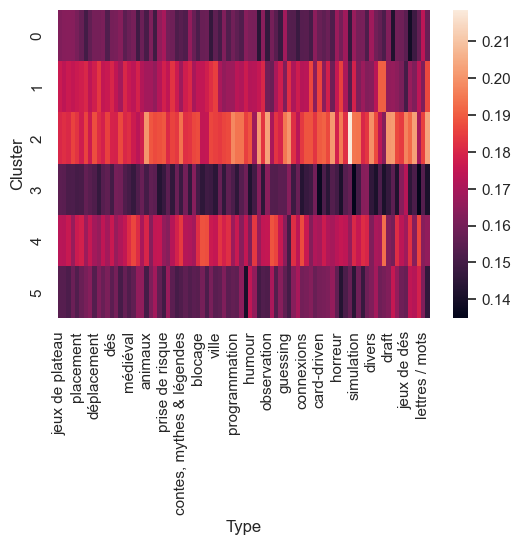

In [ ]:
clusters_tags = users_clusters.pivot_table(index="User id", columns="Cluster", aggfunc='size', fill_value=0).T @ users_tags
clusters_tags_normal = clusters_tags / clusters_tags.sum(axis=0) # normalize
sns.heatmap(clusters_tags_normal)